### plotting with seaborn
only use under analysis environment 

In [1]:
import os
import numpy as np
import seaborn as sns
import pandas as pd

import re

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator

# use seaborn for easier logrithmic color scale

In [2]:
def find_mousename(text):
    #finds name of mouse that follows the typical LSENS pattern: two letters followed by 3 numbers, ie AL000
    a= re.search('[a-zA-Z]{2}[0-9]{2,3}', text)
    return a[0]

def prep_df(df):
    # prepares df so that we only keep the id and total count
    # input is the full path and name of the .csv file
    read_file= pd.read_excel(df)
    
    #new= read_file.set_index('id').sort_values(by='graph_order').T
    #This lines sorts the region ids according to its graph order, such that related regions are ordered together 
    # ie, barrel field layers are grouped together
    # Note that this order would be disrupted when you have to later concatenate dfs with different columns...so need to rearrange later
    
    
    new= read_file.set_index('acronym').T
    new_series=new.loc['counts']

    full_df= new_series.to_frame()
    full_df.rename(columns={'counts': find_mousename(df)}, inplace=1)
    return full_df

def combine_df(folder,list_of_fname,inner=False):
    # combine multiple data frames, keeping only mouse name, region id and amount of um
    # by default, returns all of the regions that at least one brain that projects to it
    # if inner=True, then only return regions that overlaps in all brains
    
    #initialize a dataframe which will later be removed
    full_name_initial=os.path.join(folder, list_of_fname[0])
    full_df=prep_df(full_name_initial)
    
    if inner==True:
        for i in (list_of_fname):
            new_df=prep_df(os.path.join(folder, i))
            full_df=full_df=pd.concat([full_df, new_df],axis=1, join='inner')

    else: 
        for i in (list_of_fname):
            new_df=prep_df(os.path.join(folder, i))
            full_df=full_df=pd.concat([full_df, new_df],axis=1)

    full_df=full_df.T.iloc[1:]
    return full_df


def prep_df_specific(df,region_id=''):
    '''Look for regions belong to one of the group by specifying region_id = : 
    343 brainstem
    567 cerebrum
    leave empty for everything else
    ie prep_df_specific(path_to_df) gives regions not belonging to brainstem or cerebrum
    prep_df_specific(path_to_df, region_id =343) gives regions belonging to brainstem only
    '''
    
    # prepares df so that we only keep the id and total count
    # input is the full path and name of the .csv file
    read_file= pd.read_excel(df)
    
    #new= read_file.set_index('id').sort_values(by='graph_order').T
    #This lines sorts the region ids according to its graph order, such that related regions are ordered together 
    # ie, barrel field layers are grouped together
    # Note that this order would be disrupted when you have to later concatenate dfs with different columns...so need to rearrange later
    
    if region_id:
        specific_df=read_file.loc[read_file['structure_id_path'].str.contains(f'/{region_id}/', case=False)]
    else:
        searchfor = ['/343/','/567/']
        specific_df= read_file.loc[~read_file['structure_id_path'].str.contains('|'.join(searchfor), case=False)]            
    
    new= specific_df.set_index('acronym').T
    new_series=new.loc['counts']

    full_df= new_series.to_frame()
    full_df.rename(columns={'counts': find_mousename(df)}, inplace=1)
    return full_df

def combine_df_specific(folder,list_of_fname,region_id=''):
    
    '''    # combine multiple data frames, keeping only mouse name, region id and amount of voxels
    by default, returns all of the regions that at least one brain that projects to it
    region_id specifies to look for brain regions only belonging to brainstem(343), cerebrum(567) or all others('')'''

    #initialize a list for data frames to combine
    df_list = []
    for i in parent_axons:
        this_df = prep_df_specific(os.path.join(folder, i),region_id=region_id).T
        df_list.append(this_df)
    full_df = pd.concat(df_list)

    return full_df

# def combine_df_specific_new(folder,list_of_fname,region_id='', inner=False):
    
#     ''' !! Use this one becase combine_df_specific does not work in some cases which I havn't figured out why... 
#     combine multiple data frames, keeping only mouse name, region id and amount of voxels
#     by default, returns all of the regions that at least one brain that projects to it
#     region_id specifies to look for brain regions only belonging to brainstem(343), cerebrum(567) or all others('')'''
    
#     full_df=pd.DataFrame(columns=['acronym'])
#     for i in list_of_fname:
#         this_df = prep_df_specific(os.path.join(folder, i),region_id=region_id)
#         full_df=pd.merge(full_df,this_df,on='acronym', how='outer')
#     return full_df.set_index('acronym')

### log scale heatmap for axons in brain region

In [20]:
#find all relevant files
folder= r'D:\viral_results\s1'
outdir = r'D:\viral_results\s1_results'

files= [ i for i  in os.listdir(folder) if 'with_counts' in i]


In [29]:
side='left'
parent_axons= [ i for i  in os.listdir(folder) if 'Lparent' in i]
#change side to right and Rparent for the other hemisphere!

In [5]:
#parent_axons

In [30]:
axonal_df= combine_df(folder, parent_axons)
axonal_df=axonal_df.T


In [31]:
axonal_df.columns

Index(['AL207', 'AL209', 'AL211', 'AL213', 'AL215', 'AL254', 'AL255', 'AL257',
       'AL273', 'AL274', 'AL285', 'AL290', 'AL291', 'AL292', 'AL293', 'AL311',
       'AL313', 'AL314', 'AL318'],
      dtype='object')

In [32]:
column_order= ['AL254', 'AL255', 'AL257','AL290','AL291','AL292','AL293','AL213','AL313','AL314',
               'AL211', 'AL215','AL318', 'AL207','AL209','AL273','AL274','AL285','AL311']
# for verified s1 injections as of april .2023

#column_order= ['AL303','AL332','AL333','AL290','AL292','AL323', 'AL278', 'AL280', 'AL319', 'AL288', 'AL326', 'AL327',
#              'AL281', 'AL286', 'AL321', 'AL322', 'AL274', 'AL310', 'AL330']
#for s2 injections as of June.2023

final=axonal_df[column_order]
df=final.fillna(0.00000000001)
#fill Nan with a very small number since the sns heat map do not accept nan

In [33]:
y=final.index.to_list()
test_order=[]

atlas_labels=pd.read_csv('D:\Allenbrainatlas\ARA_25_micron_mhd_ccf2017\labels.csv')

for i in y:
    name=atlas_labels.query(f"acronym== '{i}'").graph_order.values[0]
    test_order.append(name)

# get all the acronyms involved and their graphorder

In [34]:
sort_acronym_df= pd.DataFrame({'acronyms':y, 'graph_order': test_order})
sort_acronym_df.sort_values('graph_order', inplace=True)
# sort the aconnyms based on parent structure id

In [35]:
final_df= df.reindex(sort_acronym_df.acronyms.to_list())
#final_df

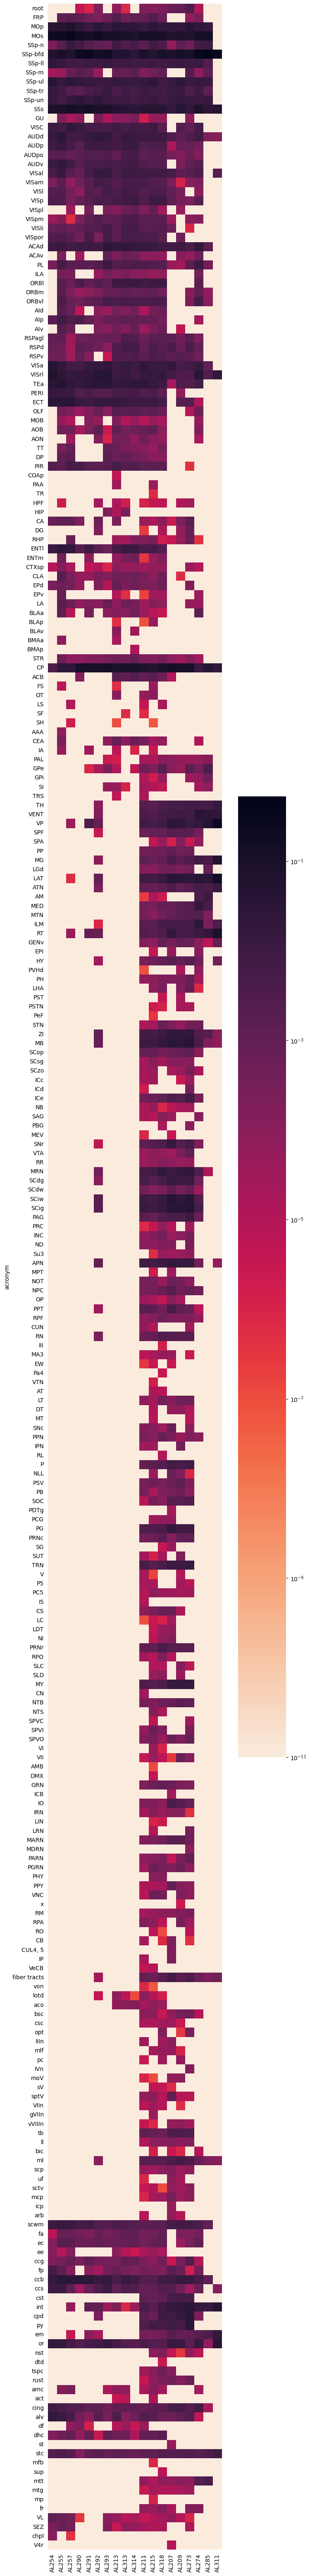

In [36]:
fig, ax = plt.subplots(figsize=(10,80))
g1= sns.heatmap(final_df, norm=LogNorm(), cmap="rocket_r", square=True,linewidths=0.0, rasterized=True)

g1.tick_params(bottom=False, left=False)
# disable ticks because it is such a mess in illustrator!

plt.rcParams['svg.fonttype'] = 'none'
# so text stay as text not paths!


plt.savefig(f'{outdir}\{side}_heatmap_logscale.svg')
plt.show()

### plotting correlation matrix with sns

In [3]:
indir= r'D:\viral_results\s1'
outdir = r'D:\viral_results\s1_results'

In [4]:
column_order= ['AL254', 'AL255', 'AL257','AL290','AL291','AL292','AL293','AL213','AL313','AL314',
               'AL211', 'AL215','AL318', 'AL207','AL209','AL273','AL274','AL285','AL311']
# for verified s1 injections as of april .2023

#column_order= ['AL303','AL332','AL333','AL290','AL292','AL323', 'AL278', 'AL280', 'AL319', 'AL288', 'AL326', 'AL327',
#             'AL281', 'AL286', 'AL321', 'AL322', 'AL274', 'AL310', 'AL330']
#for s2 injections as of june.2023

In [5]:
axons_L= [ i for i  in os.listdir(indir) if 'axon_left' in i]
axonal_df_L= combine_df(indir, axons_L)
axonal_df_L.fillna(0, inplace=True)

axonal_df_L=axonal_df_L.T

axonal_df_L_ordered=axonal_df_L[column_order]
#order



In [6]:
axons_R= [ i for i  in os.listdir(indir) if 'axon_right' in i]
axonal_df_R= combine_df(indir, axons_R)
axonal_df_R.fillna(0, inplace=True)

axonal_df_R=axonal_df_R.T

axonal_df_R_ordered=axonal_df_R[column_order]
#order

#axonal_df_R_ordered['AL310'][0]=0.00000
# No need to do this if plotting the full correlation (both hemispheres), only do this for plotting right hemisphere correlaiton
# because some brains(such as AL285) have nothing at all in the right hemisphere, correlation will show up as NAN and hence a blank row/column in heatmap
# just assign 1 to a random item so this does not happen

In [7]:
right_acronym= [i+'_right' for i in axonal_df_R.index]
axonal_df_R['acronym']=right_acronym

axonal_df_R.set_index('acronym', inplace=True)
#Rename everything on the right side to preserve some spatial info

In [8]:
full_df=pd.concat([axonal_df_L,axonal_df_R])
full_df=full_df[column_order]
#full_df

In [9]:
full_corr=full_df.corr()


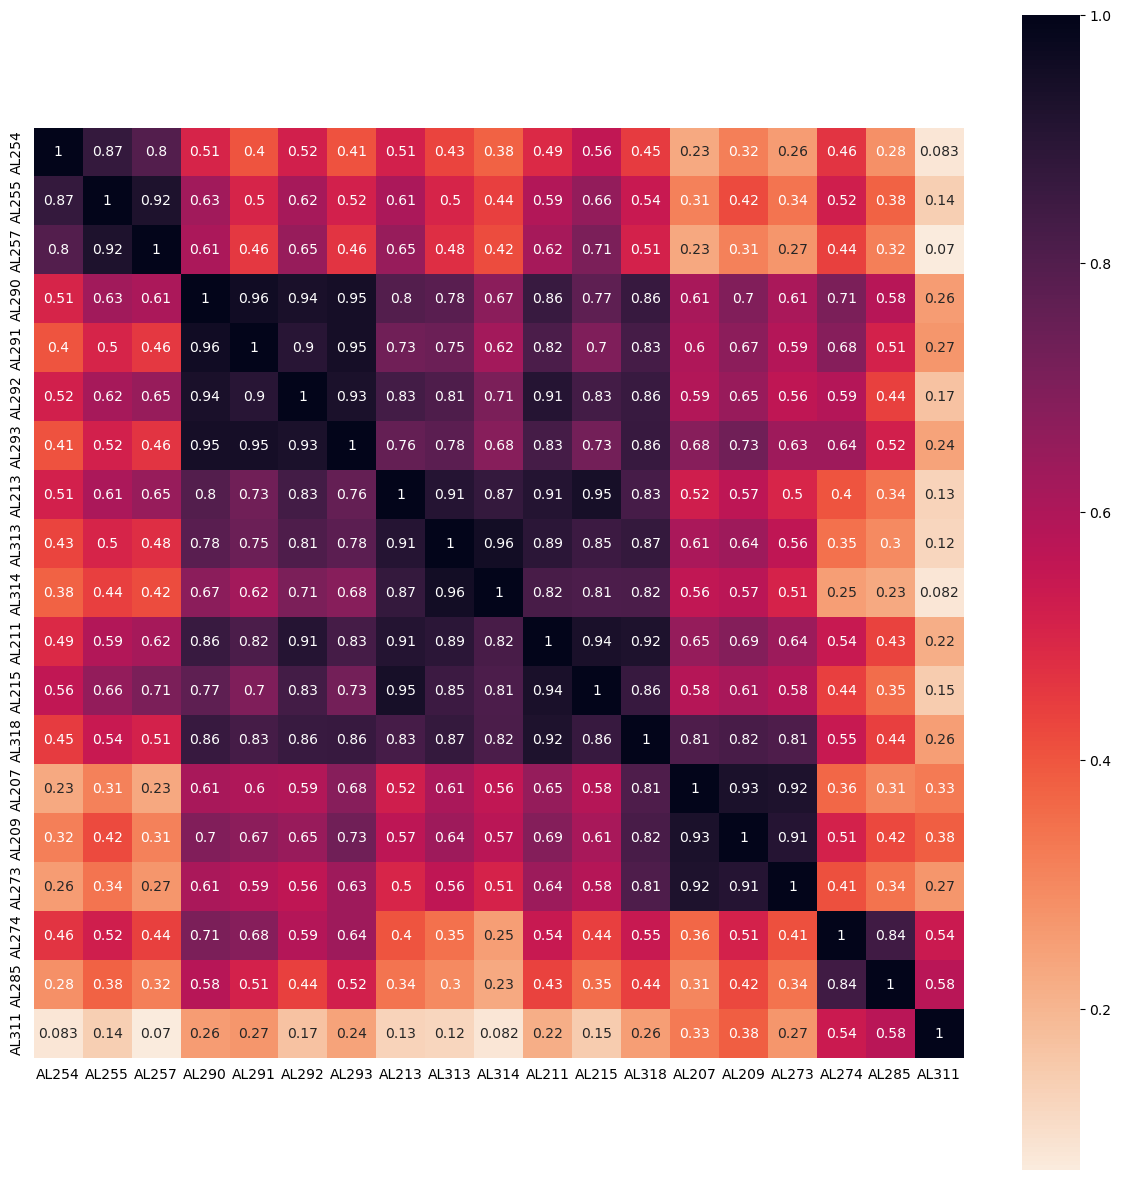

In [10]:

fig, ax = plt.subplots(figsize=(15,15))
g1=sns.heatmap(full_corr,  cmap="rocket_r", annot=True, square=True,linewidths=0.0, rasterized=True)
# set line width=0 and rasterized= true because when importing svg in illustrator, random whitelines are showing!

g1.tick_params(bottom=False, left=False)
# disable ticks because it is such a mess in illustrator!

plt.rcParams['svg.fonttype'] = 'none'
# so text stay as text not paths!

plt.savefig(f'{outdir}\\full_correlation.svg')
plt.show()

### section to plot bar graphs- a given region for a single injection site

In [2]:
outdir= r'D:\\viral_results\\s1_s2'

In [3]:
region='s2'
mouseline='ras'
side='left'

file_path= f'D:\\viral_results\\s1_s2\\{region}_{mouseline}_avg_{side}_region_with_counts.xlsx'
read_file= pd.read_excel(file_path)


some ids to consider

isocortex 315

    somatomotor areas 500
    somatosensory areas 453
    Temporal association area 541
    perirhinal area 922
    ectorhinal area 895
    ..and others


In [73]:
# get regions belonging to isocortex only
region_id='500'
choosen_regions= read_file.loc[read_file['structure_id_path'].str.contains(f'/{region_id}/', case=False)]


In [74]:
choosen_regions= choosen_regions.sort_values('graph_order', ascending=True)
# sort based on the graph order so more related regions are together

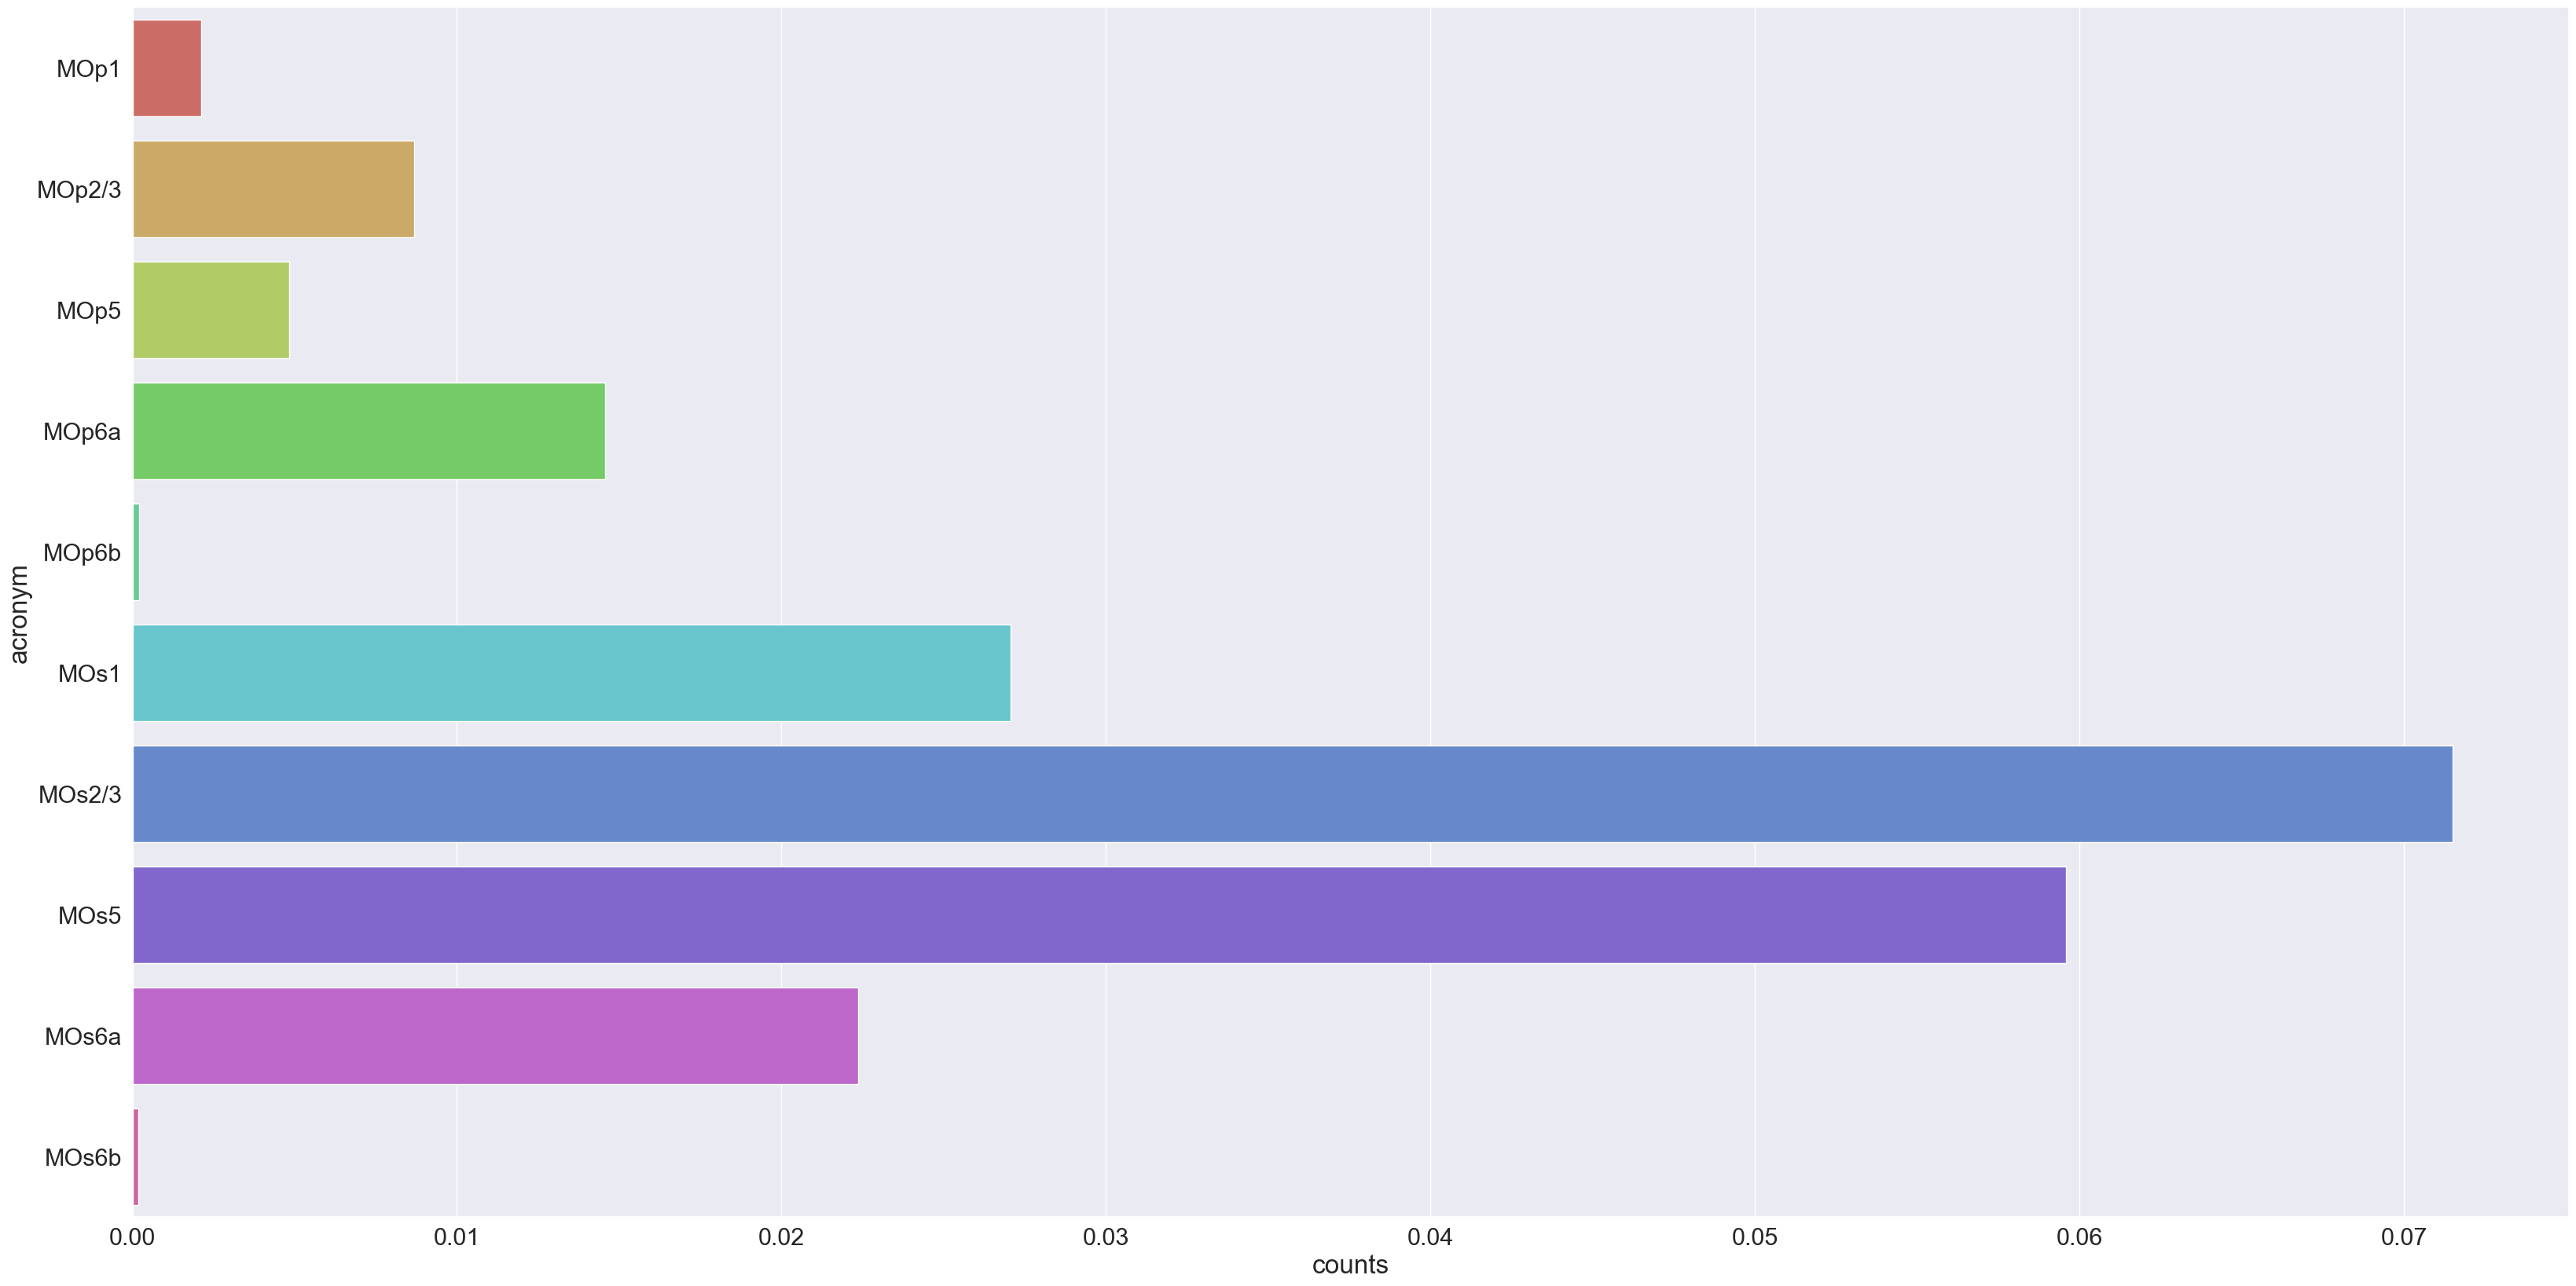

In [75]:
sns.set(font_scale=2)

fig, ax = plt.subplots(figsize=(40,20))
g1=sns.barplot(data=choosen_regions, y="acronym", x="counts", palette="hls", orient="h")

g1.tick_params(bottom=False, left=False)
# disable ticks because it is such a mess in illustrator!

plt.rcParams['svg.fonttype'] = 'none'
# so text stay as text not paths!

plt.savefig(f'{outdir}\\{region}_{mouseline}_avg_{side}_{region_id}.svg')
plt.show()

### section to plot bar graphs- a given region for s1 vs s2 comparison for a given layer

In [4]:
outdir= r'D:\\viral_results\\s1_s2'

mouseline='ras'
side='left'

# read in the two data frames
region='s1'
file_path= f'D:\\viral_results\\s1_s2\\{region}_{mouseline}_avg_{side}_region_with_counts.xlsx'
read_file= pd.read_excel(file_path)
read_file['injection']=region

region2='s2'
file_path2= f'D:\\viral_results\\s1_s2\\{region2}_{mouseline}_avg_{side}_region_with_counts.xlsx'
read_file2= pd.read_excel(file_path2)
read_file2['injection']=region2


In [5]:
both_df= pd.concat([read_file, read_file2])


In [9]:
region_id='315'
choosen_regions= both_df.loc[both_df['structure_id_path'].str.contains(f'/{region_id}/', case=False)]

choosen_regions= choosen_regions.sort_values('graph_order', ascending=True)
# sort based on the graph order so more related regions are together

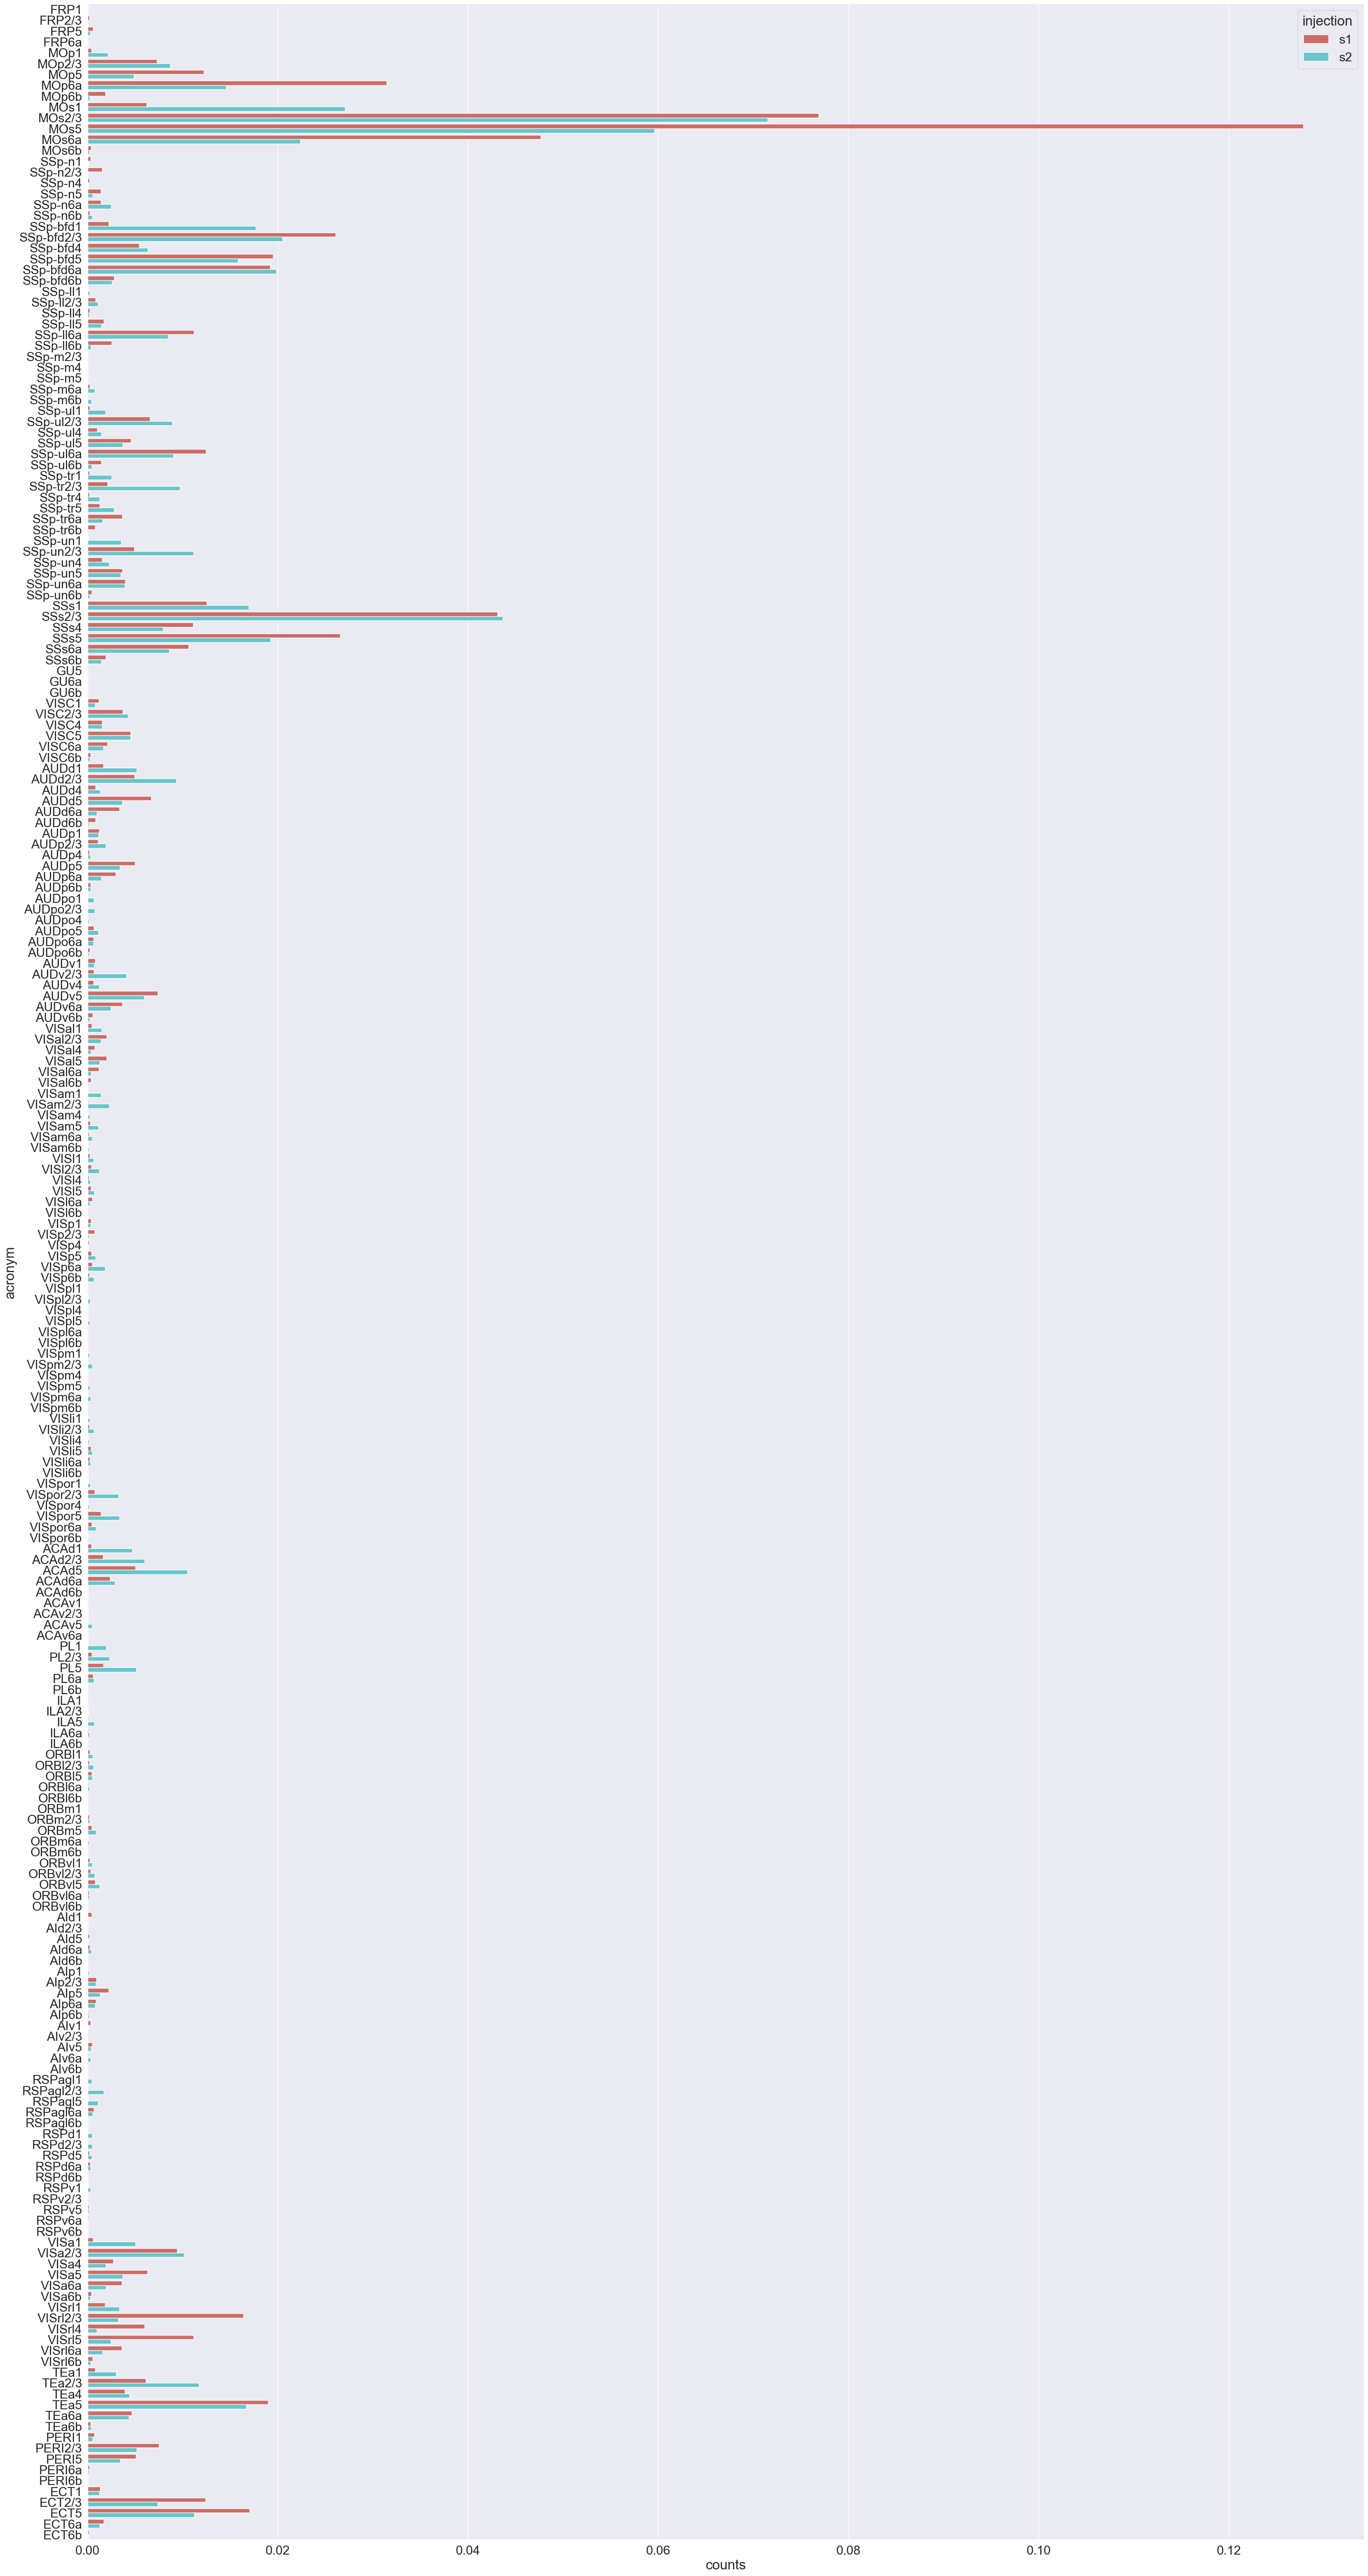

In [10]:
sns.set(font_scale=2)

fig, ax = plt.subplots(figsize=(40,80))
g1=sns.barplot(data=choosen_regions, y="acronym", x="counts", hue= "injection", palette="hls", orient="h")

g1.tick_params(bottom=False, left=False)
# disable ticks because it is such a mess in illustrator!

plt.rcParams['svg.fonttype'] = 'none'
# so text stay as text not paths!

plt.savefig(f'{outdir}\\{mouseline}_avg_{side}_{region_id}.svg')
plt.show()

### section to plot bar graphs- a givne region for one injection site for all lines

In [84]:
WORK IN PROGRESS

outdir= r'D:\\viral_results\\s1_s2'

injsite='s1'
side='left'

# read in the two data frames
region='s1'
file_path= f'D:\\viral_results\\s1_s2\\{region}_{mouseline}_avg_{side}_region_with_counts.xlsx'
read_file= pd.read_excel(file_path)
read_file['injection']=region

region2='s2'
file_path2= f'D:\\viral_results\\s1_s2\\{region2}_{mouseline}_avg_{side}_region_with_counts.xlsx'
read_file2= pd.read_excel(file_path2)
read_file2['injection']=region2


### test section for hierarchical clustering

In [31]:
#final_df=final_df.rename(columns={'AL254': "ras1", 'AL255': "ras2", 'AL257': "ras3",
                         'AL290': "scn1", 'AL291': "scn2", 'AL292': "scn3",'AL293': "scn4",
                         'AL213': "tlx1", 'AL313': "tlx2", 'AL314': "tlx3",
                         'AL211': "rbp1", 'AL215': "rbp1", 'AL318': "rbp1",
                         'AL207': "sim1", 'AL209': "sim2", 'AL273': "sim3",
                         'AL274': "nts1", 'AL285': "nts2", 'AL311': "nts3",
                        })

#rearrange columns for sns.clustermap since it always wants to arrange columns in a weird way


C:\Users\liu\AppData\Local\Continuum\anaconda3\envs\analysis\lib\site-packages\seaborn\matrix.py:657: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


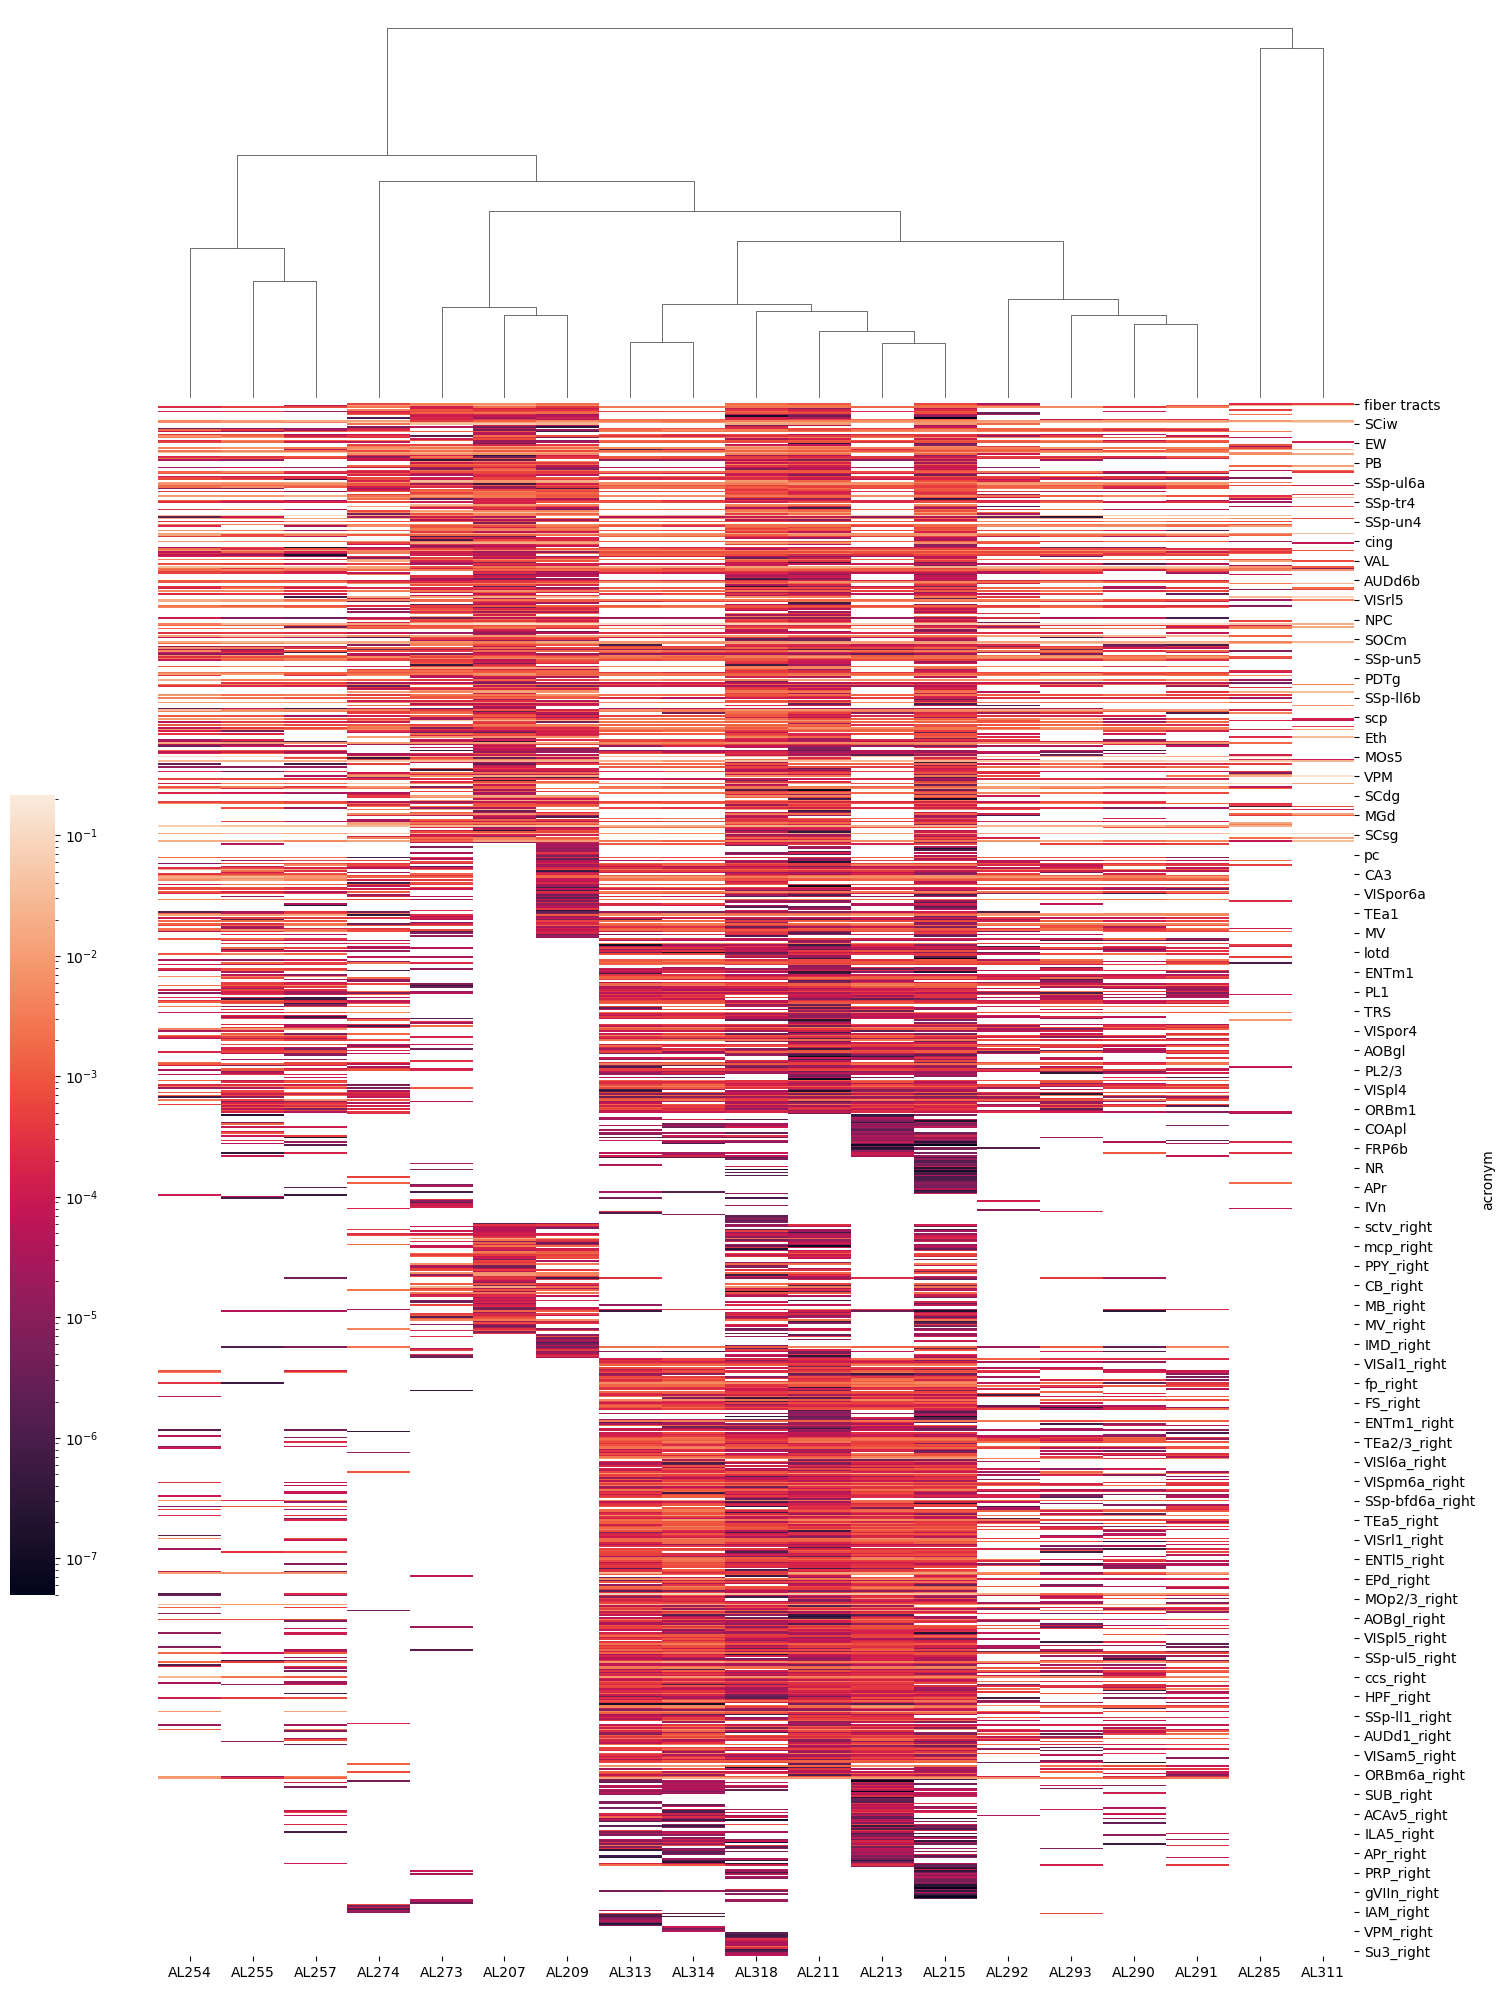

In [12]:
sns.clustermap(
    full_df,
    figsize=(15, 20),
    norm=LogNorm(),
    row_cluster=False,
    dendrogram_ratio=(.1, .2),
    cbar_pos=(0, .2, .03, .4)
)

WORK IN PROGRESS
# still in a weird way after rearrangement,...need to look up